In [1]:
# importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import ccf

In [2]:
# reading the dataset
df = pd.read_csv('Database.csv')
df.head()

,Unnamed: 0,Time,Season,Day_of_the_week,DHI,DNI,GHI,Wind_speed,Humidity,Temperature,PV_production,Wind_production,Electric_demand
0,0,2019-01-01-T00:00,1,1,0.0,0.0,0.0,2.88,56.036,1.82,0,2810,22216
1,1,2019-01-01-T00:05,1,1,0.0,0.0,0.0,2.88,56.036,1.82,0,2862,22106
2,2,2019-01-01-T00:10,1,1,0.0,0.0,0.0,2.88,56.194,1.78,0,2916,22130
3,3,2019-01-01-T00:15,1,1,0.0,0.0,0.0,2.88,56.344,1.74,0,2920,22040
4,4,2019-01-01-T00:20,1,1,0.0,0.0,0.0,2.84,56.440,1.72,0,2902,21963


In [3]:
df.describe()

,Unnamed: 0,Season,Day_of_the_week,DHI,DNI,GHI,Wind_speed,Humidity,Temperature,PV_production,Wind_production,Electric_demand
count,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000
mean,157823.500000,2.508212,2.998175,53.779907,288.058615,221.787985,2.545759,51.261462,17.472179,3555.139722,2019.642526,24833.695287
std,91119.873222,1.117189,1.997720,68.829995,336.057040,296.632914,1.042771,16.319826,7.701694,4371.602324,1300.285246,4859.658254
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.660000,11.572000,-0.540000,-145.000000,-2476.000000,14662.000000
25%,78911.750000,2.000000,1.000000,0.000000,0.000000,0.000000,1.760000,38.380000,11.200000,-34.000000,866.000000,21368.000000
50%,157823.500000,3.000000,3.000000,7.600000,38.000000,10.200000,2.340000,51.662000,16.700000,110.000000,1829.000000,23879.000000
75%,236735.250000,4.000000,5.000000,98.800000,601.600000,427.200000,3.160000,63.644000,22.800000,7952.000000,3053.000000,26814.000000
max,315647.000000,4.000000,6.000000,431.000000,999.800000,1058.200000,8.540000,88.688000,39.020000,13191.000000,5743.000000,47067.000000


# Preprocessing

In [4]:
# droping redundant index column
df = df.drop(columns = ['Unnamed: 0'])

# checking the datatypes of the columns
print(df.info())

# converting the datatype of time column to datatime
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index("Time")
# extracting attributes from Time attribute
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Date'] = df.index.date

# Removing negative values in energy production series
df['PV_production'] = abs(df['PV_production'])
df['Wind_production'] = abs(df['Wind_production'])

# Combining the energy generated by both sources
df['Energy_produced'] = df['PV_production'] + df['Wind_production']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315648 entries, 0 to 315647
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             315648 non-null  object 
 1   Season           315648 non-null  int64  
 2   Day_of_the_week  315648 non-null  int64  
 3   DHI              315648 non-null  float64
 4   DNI              315648 non-null  float64
 5   GHI              315648 non-null  float64
 6   Wind_speed       315648 non-null  float64
 7   Humidity         315648 non-null  float64
 8   Temperature      315648 non-null  float64
 9   PV_production    315648 non-null  int64  
 10  Wind_production  315648 non-null  int64  
 11  Electric_demand  315648 non-null  int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 28.9+ MB
None


In [5]:
df.describe()

,Season,Day_of_the_week,DHI,DNI,GHI,Wind_speed,Humidity,Temperature,PV_production,Wind_production,Electric_demand,Month,Year,Energy_produced
count,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000,315648.000000
mean,2.508212,2.998175,53.779907,288.058615,221.787985,2.545759,51.261462,17.472179,3579.848068,2019.848724,24833.695287,6.521898,2020.000000,5599.696792
std,1.117189,1.997720,68.829995,336.057040,296.632914,1.042771,16.319826,7.701694,4351.392027,1299.964916,4859.658254,3.448992,0.816125,4335.612400
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.660000,11.572000,-0.540000,0.000000,0.000000,14662.000000,1.000000,2019.000000,10.000000
25%,2.000000,1.000000,0.000000,0.000000,0.000000,1.760000,38.380000,11.200000,35.000000,866.000000,21368.000000,4.000000,2019.000000,1995.000000
50%,3.000000,3.000000,7.600000,38.000000,10.200000,2.340000,51.662000,16.700000,111.000000,1830.000000,23879.000000,7.000000,2020.000000,3882.000000
75%,4.000000,5.000000,98.800000,601.600000,427.200000,3.160000,63.644000,22.800000,7952.000000,3053.000000,26814.000000,10.000000,2021.000000,9631.000000
max,4.000000,6.000000,431.000000,999.800000,1058.200000,8.540000,88.688000,39.020000,13191.000000,5743.000000,47067.000000,12.000000,2021.000000,17582.000000


In [6]:
# check missing values
df.isna().sum()

Season             0
Day_of_the_week    0
DHI                0
DNI                0
GHI                0
Wind_speed         0
Humidity           0
Temperature        0
PV_production      0
Wind_production    0
Electric_demand    0
Month              0
Year               0
Date               0
Energy_produced    0
dtype: int64

# EDA

### Time series plots

In [7]:
# time series plot
def time_series_plot(df, title, y_label, x_label):
    df.plot(title = title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()




/tmp/ipykernel_177754/2027967350.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df[['PV_production', 'Wind_production', 'Electric_demand']].resample('M').mean(),


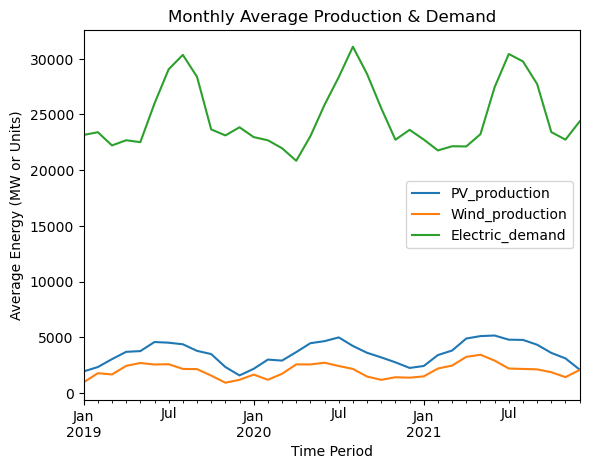

In [8]:
time_series_plot(
    df[['PV_production', 'Wind_production', 'Electric_demand']].resample('M').mean(), 
    title="Monthly Average Production & Demand", 
    y_label="Average Energy (MW or Units)", 
    x_label="Time Period"
)

/tmp/ipykernel_177754/2525166067.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df[['Energy_produced', 'Electric_demand']].resample('M').mean(),


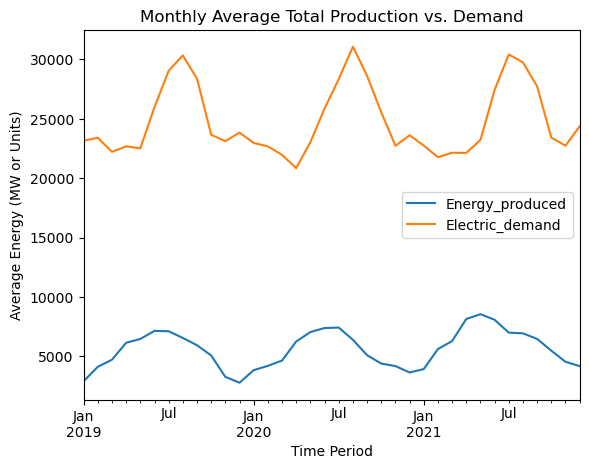

In [9]:
# analysing the gap between production and demand
time_series_plot(
    df[['Energy_produced', 'Electric_demand']].resample('M').mean(), 
    title="Monthly Average Total Production vs. Demand", 
    y_label="Average Energy (MW or Units)", 
    x_label="Time Period"
)

### Correlation analysis

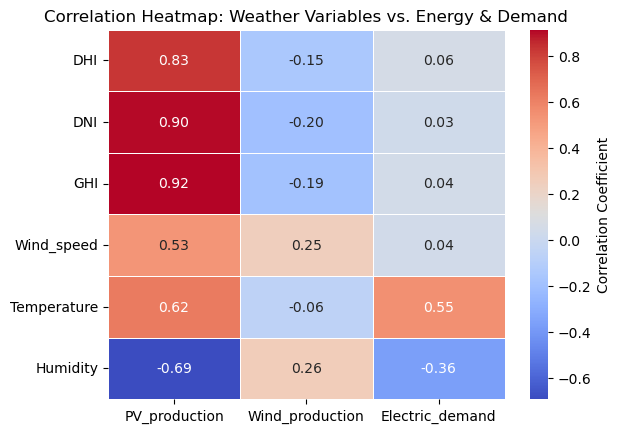

In [10]:
# Defining the variables for correlation analysis
weather_vars = ['DHI', 'DNI', 'GHI', 'Wind_speed', 'Temperature', 'Humidity']
production_vars = ['PV_production', 'Wind_production', 'Electric_demand']
corr_df = df[weather_vars + production_vars]
correlation_matrix = corr_df.corr()
relevant_corr = correlation_matrix.loc[weather_vars, production_vars]
sns.heatmap(relevant_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap: Weather Variables vs. Energy & Demand')
plt.show()

### Seasonal Decomposition

/tmp/ipykernel_177754/3440969847.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  res_pv = seasonal_decompose(df['PV_production'].resample('M').mean(), model='additive', period=MONTHLY_PERIOD)


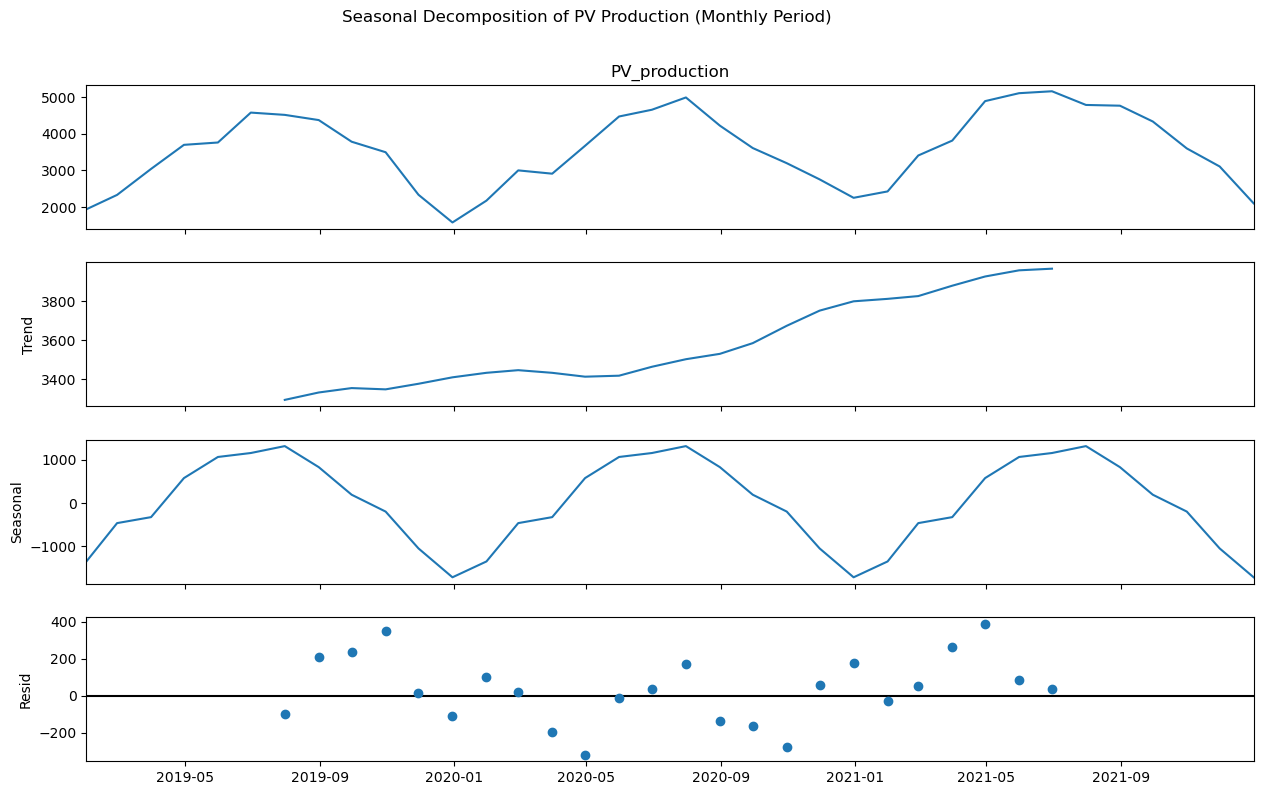

/tmp/ipykernel_177754/3440969847.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  res_wind = seasonal_decompose(df['Wind_production'].resample('M').mean(), model='additive', period=MONTHLY_PERIOD)


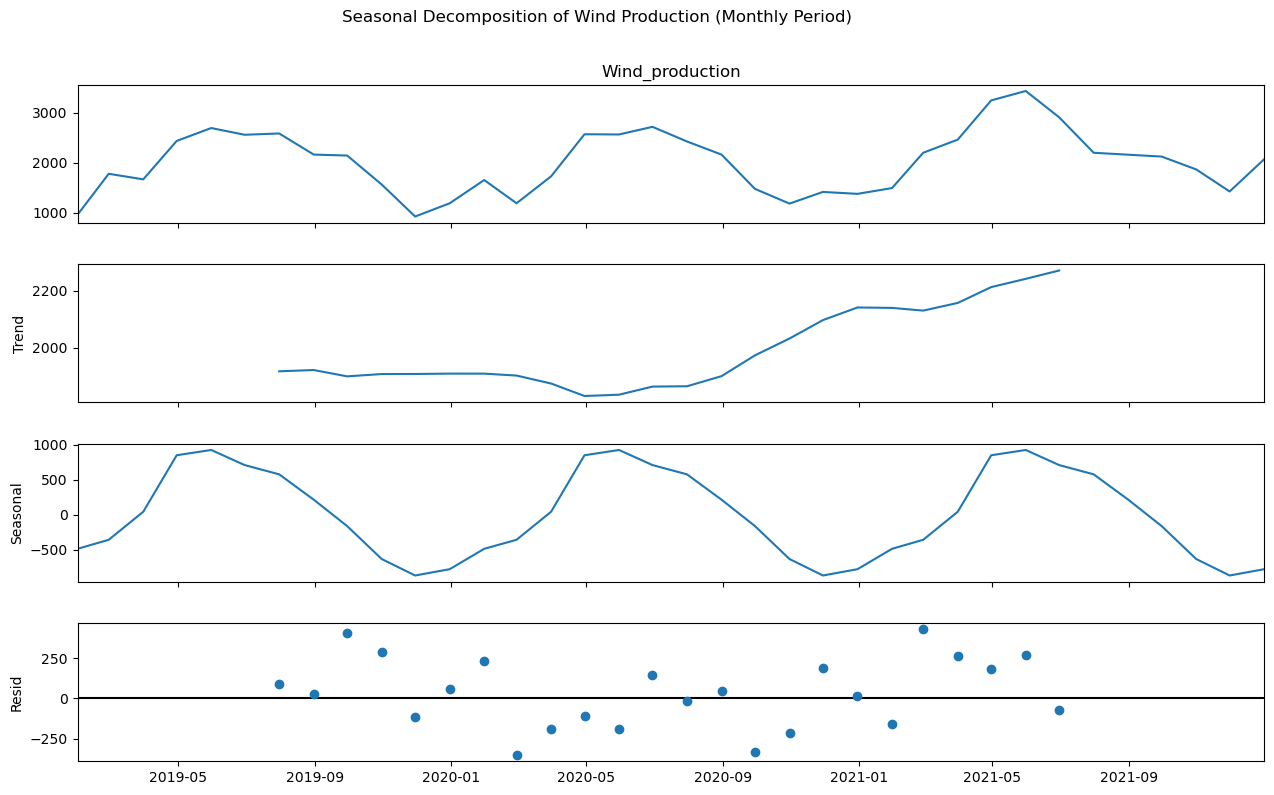

/tmp/ipykernel_177754/3440969847.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  res_demand = seasonal_decompose(df['Electric_demand'].resample('M').mean(), model='additive', period=MONTHLY_PERIOD)


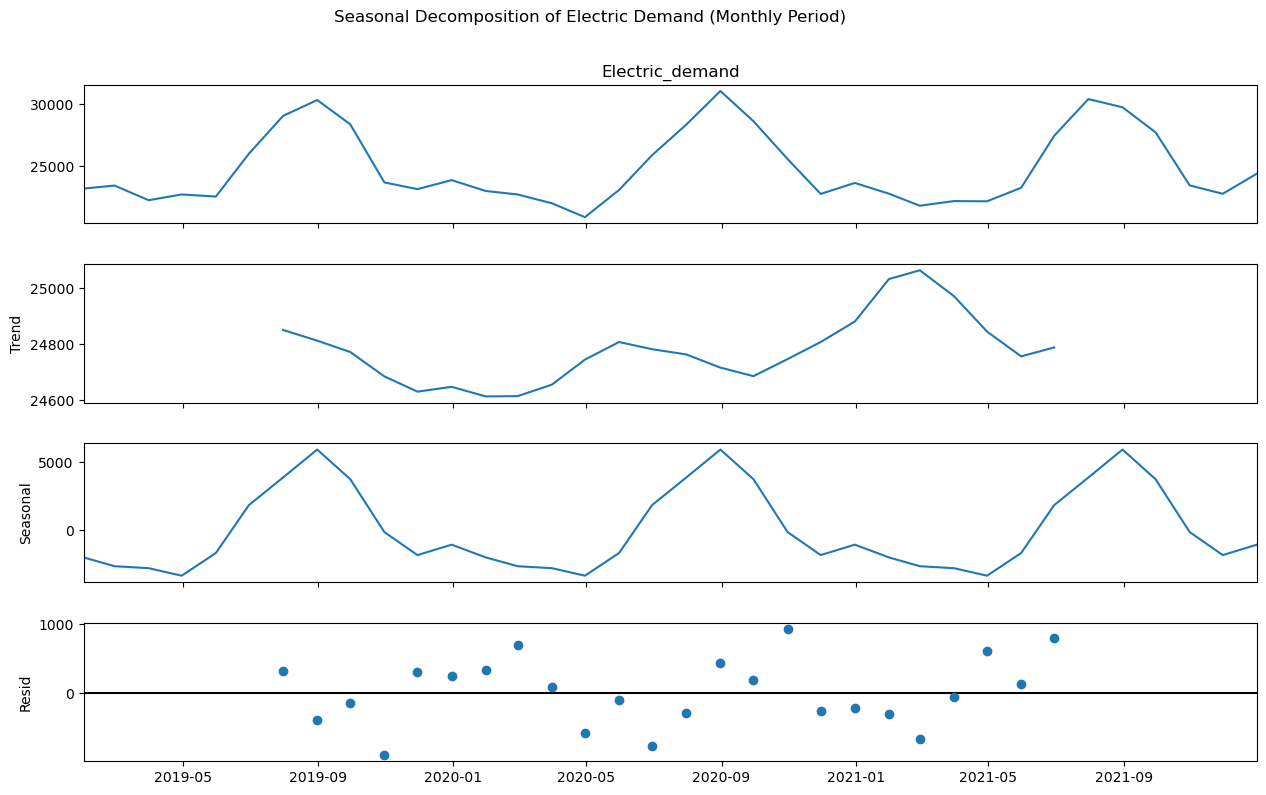

In [11]:
MONTHLY_PERIOD = 12

res_pv = seasonal_decompose(df['PV_production'].resample('M').mean(), model='additive', period=MONTHLY_PERIOD)
fig = res_pv.plot()
fig.set_size_inches(14, 8)
fig.suptitle('Seasonal Decomposition of PV Production (Monthly Period)', y=1.02)
plt.show()

res_wind = seasonal_decompose(df['Wind_production'].resample('M').mean(), model='additive', period=MONTHLY_PERIOD)
fig = res_wind.plot()
fig.set_size_inches(14, 8)
fig.suptitle('Seasonal Decomposition of Wind Production (Monthly Period)', y=1.02)
plt.show()

# Decompose Electric Demand (often has complex seasonality)
res_demand = seasonal_decompose(df['Electric_demand'].resample('M').mean(), model='additive', period=MONTHLY_PERIOD)
fig_demand = res_demand.plot()
fig_demand.set_size_inches(14, 8)
fig_demand.suptitle('Seasonal Decomposition of Electric Demand (Monthly Period)', y=1.02)
plt.show()

### checking for stationarity in the data

In [12]:
def adf_test(series, name='Time Series'):
    """
    Perform the Augmented Dickey-Fuller test.
    Null Hypothesis (H0): The series is non-stationary (has a unit root).
    Alternative Hypothesis (HA): The series is stationary.
    """
    series = series.dropna()
    
    print(f"\n--- Augmented Dickey-Fuller Test for {name} ---")

    result = adfuller(series, regression = 'n')

    df_output = pd.Series(
        result[0:4],
        index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used']
    )

    for key, value in result[4].items():
        df_output[f'Critical Value ({key})'] = value

    print(df_output)

    # Interpretation
    if result[1] <= 0.05:
        print(f"Conclusion: Reject H0 → **Stationary** (p-value <= 0.05).")
    else:
        print(f"Conclusion: Fail to Reject H0 → **Non-Stationary** (p-value > 0.05).")
    
    print("-" * 60)



In [13]:
adf_test(df['PV_production'].resample('M').mean(), 'PV Production')


--- Augmented Dickey-Fuller Test for PV Production ---
Test Statistic                  1.765107
p-value                         0.981908
Lags Used                      10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -2.660975
Critical Value (5%)            -1.955130
Critical Value (10%)           -1.608915
dtype: float64
Conclusion: Fail to Reject H0 → **Non-Stationary** (p-value > 0.05).
------------------------------------------------------------


/tmp/ipykernel_177754/2281670112.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  adf_test(df['PV_production'].resample('M').mean(), 'PV Production')


In [14]:
adf_test(df['Wind_production'].resample('M').mean(), 'Wind Production')



--- Augmented Dickey-Fuller Test for Wind Production ---
Test Statistic                  1.500452
p-value                         0.966940
Lags Used                       9.000000
Number of Observations Used    26.000000
Critical Value (1%)            -2.657098
Critical Value (5%)            -1.954532
Critical Value (10%)           -1.609176
dtype: float64
Conclusion: Fail to Reject H0 → **Non-Stationary** (p-value > 0.05).
------------------------------------------------------------


/tmp/ipykernel_177754/3255026774.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  adf_test(df['Wind_production'].resample('M').mean(), 'Wind Production')


In [15]:
adf_test(df['Electric_demand'].resample('M').mean(), 'Electricty demand')


--- Augmented Dickey-Fuller Test for Electricty demand ---
Test Statistic                  0.075634
p-value                         0.708866
Lags Used                      10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -2.660975
Critical Value (5%)            -1.955130
Critical Value (10%)           -1.608915
dtype: float64
Conclusion: Fail to Reject H0 → **Non-Stationary** (p-value > 0.05).
------------------------------------------------------------


/tmp/ipykernel_177754/611782241.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  adf_test(df['Electric_demand'].resample('M').mean(), 'Electricty demand')


In [16]:
def kpss_test(series, regression='c'):
    print("KPSS Test (H0 = Stationary)")
    statistic, p_value, lags, critical_values = kpss(series, regression=regression)

    print(f"Statistic: {statistic}")
    print(f"P-value: {p_value}")
    print(f"Lags used: {lags}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"   {key}: {value}")

    if p_value < 0.05:
        print("Reject H0 => Series is **non-stationary**")
    else:
        print("Fail to reject H0 => Series is **stationary**")


In [17]:
kpss_test(df['PV_production'].resample('M').mean())

KPSS Test (H0 = Stationary)
Statistic: 0.1289332364744001
P-value: 0.1
Lags used: 3
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Fail to reject H0 => Series is **stationary**


/tmp/ipykernel_177754/3131090614.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  kpss_test(df['PV_production'].resample('M').mean())
/tmp/ipykernel_177754/3285365713.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, regression=regression)


In [18]:
kpss_test(df['Wind_production'].resample('M').mean())


KPSS Test (H0 = Stationary)
Statistic: 0.09644184047902427
P-value: 0.1
Lags used: 3
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Fail to reject H0 => Series is **stationary**


/tmp/ipykernel_177754/3839297894.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  kpss_test(df['Wind_production'].resample('M').mean())
/tmp/ipykernel_177754/3285365713.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, regression=regression)


In [19]:
kpss_test(df['Electric_demand'].resample('M').mean())

KPSS Test (H0 = Stationary)
Statistic: 0.05492402831991963
P-value: 0.1
Lags used: 3
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Fail to reject H0 => Series is **stationary**


/tmp/ipykernel_177754/656811545.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  kpss_test(df['Electric_demand'].resample('M').mean())
/tmp/ipykernel_177754/3285365713.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, regression=regression)


In [20]:
def plot_acf_pacf(series, name, lags=30):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(series, lags=lags, ax=axes[0], title=f'ACF for {name}')
    plot_pacf(series, lags=lags//2, ax=axes[1], title=f'PACF for {name}', method='ywm')

    axes[0].axhline(0, linestyle='--', color='gray')
    axes[1].axhline(0, linestyle='--', color='gray')
    
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_177754/3818265460.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = df[series].resample('M').mean().dropna()


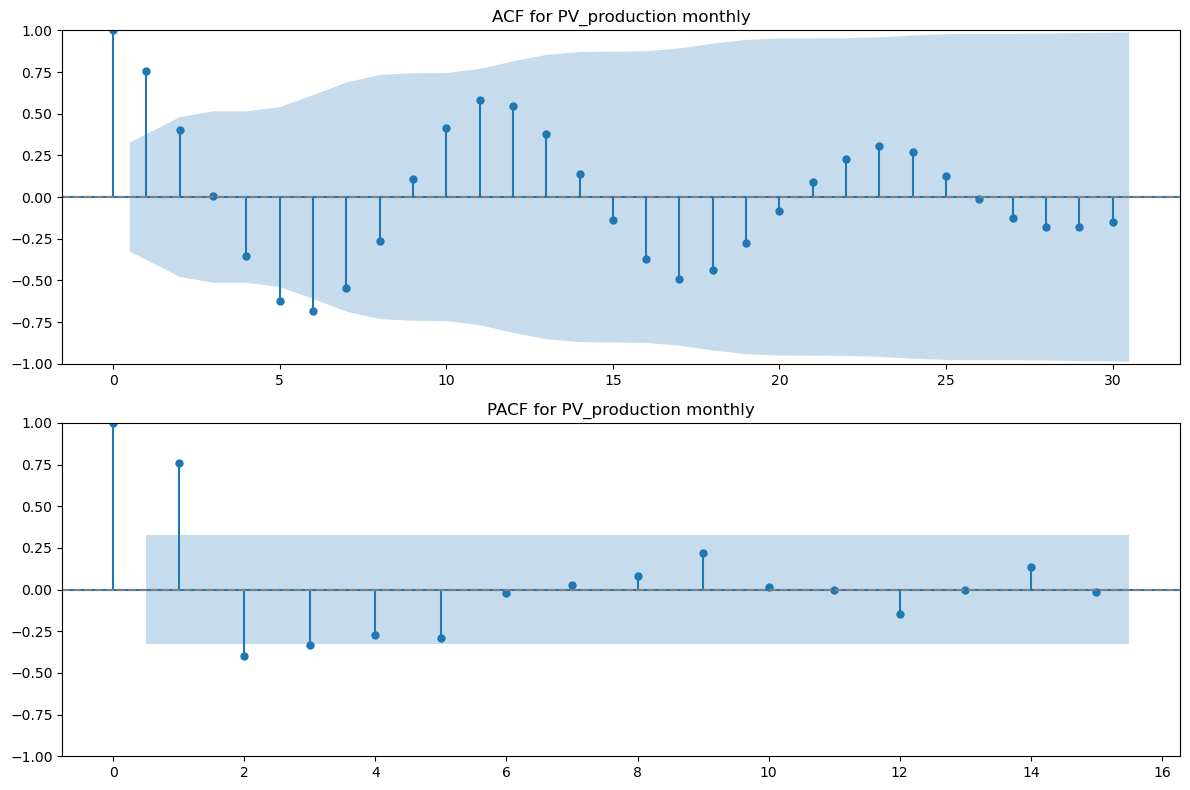

/tmp/ipykernel_177754/3818265460.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = df[series].resample('M').mean().dropna()


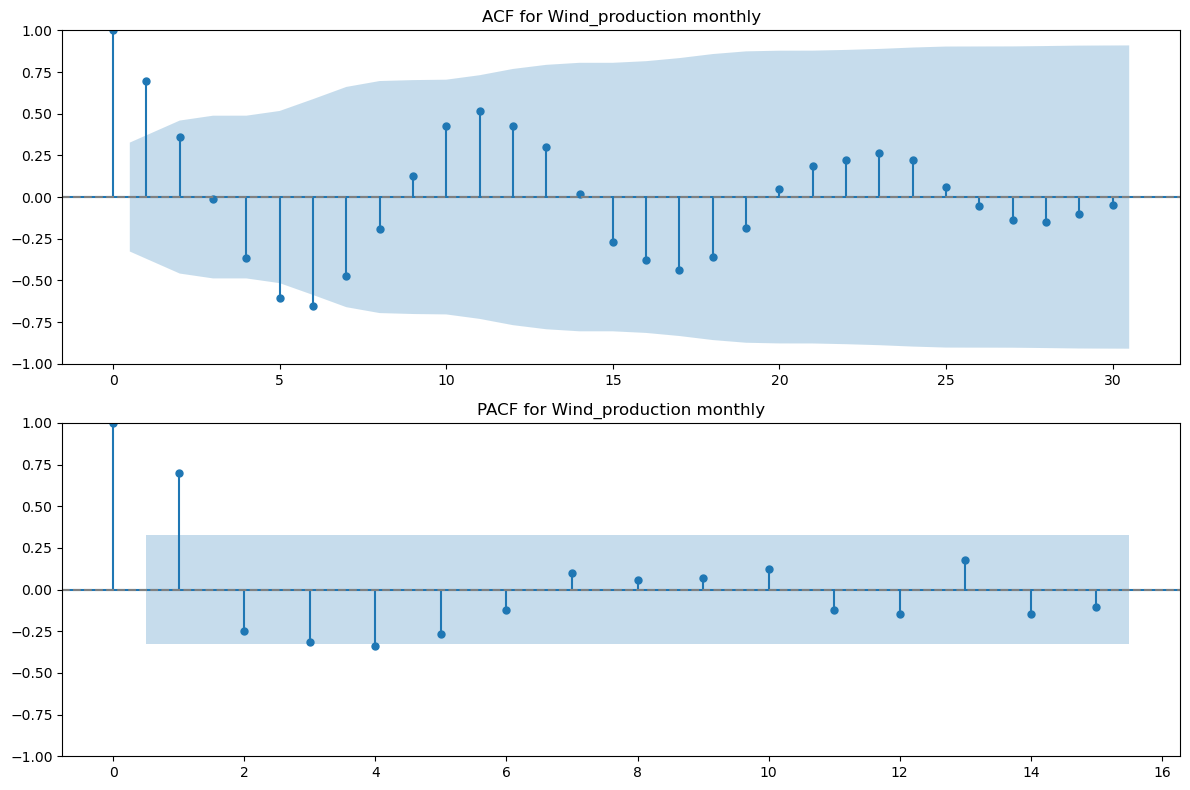

/tmp/ipykernel_177754/3818265460.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = df[series].resample('M').mean().dropna()


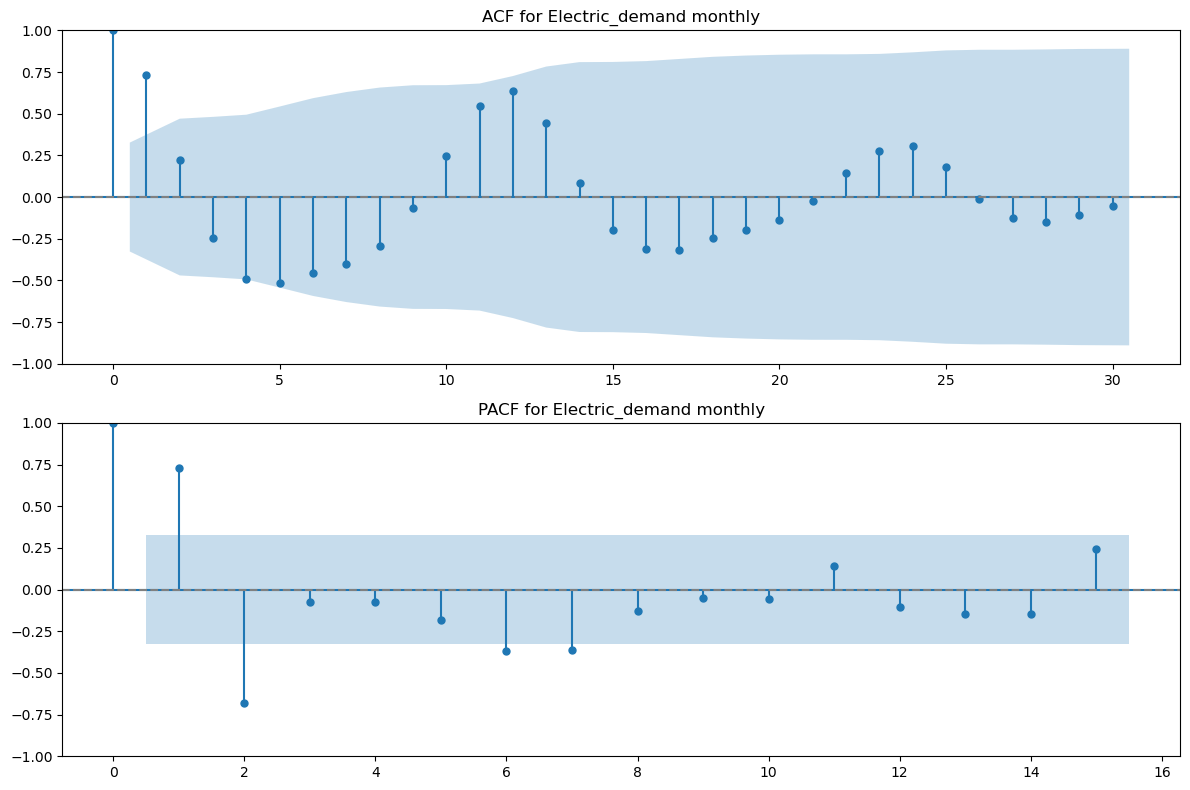

In [21]:
series_list = ['PV_production', 'Wind_production', 'Electric_demand']
for series in series_list:
    df2 = df[series].resample('M').mean().dropna()
    plot_acf_pacf(df2, f'{series} monthly')


## Cross correlation analysis 

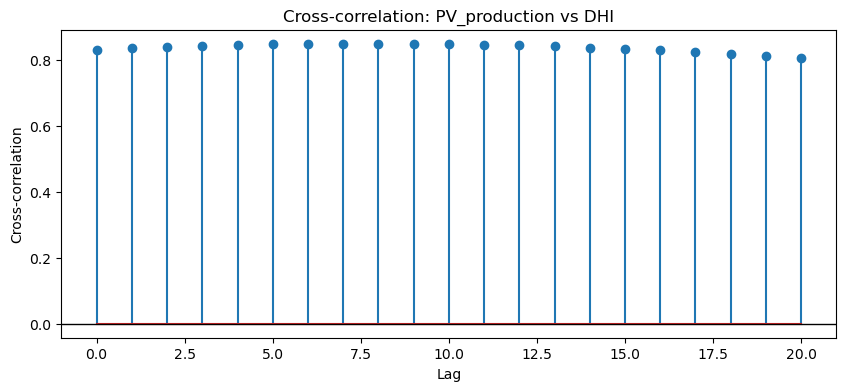

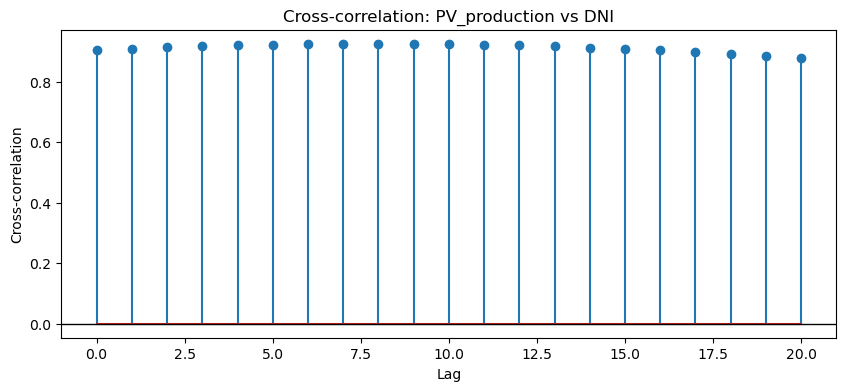

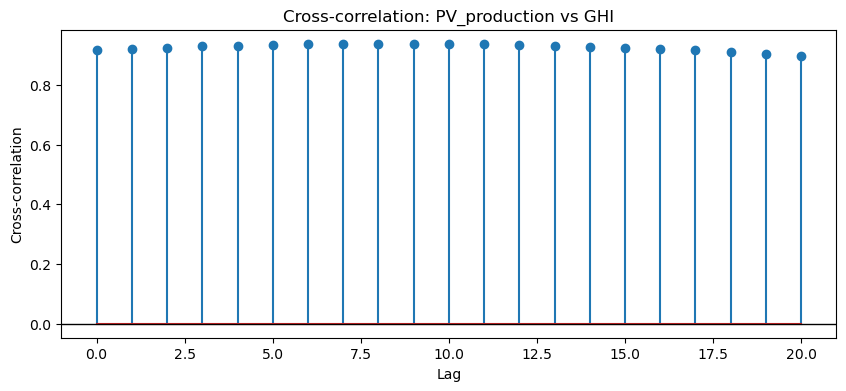

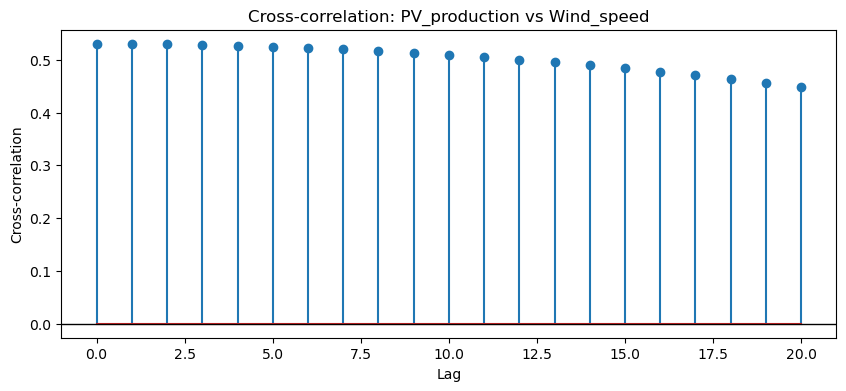

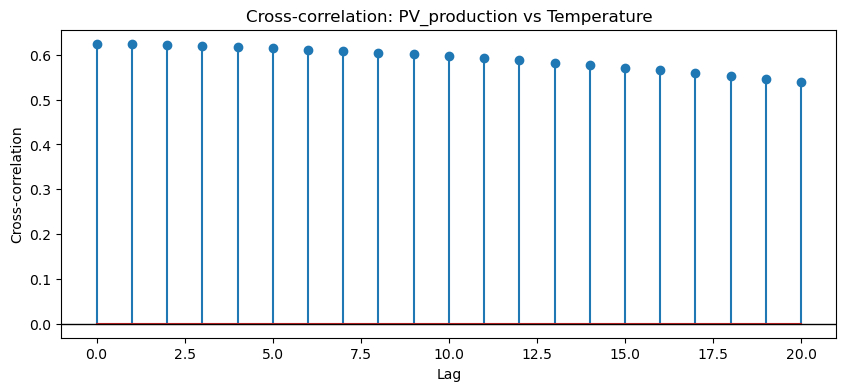

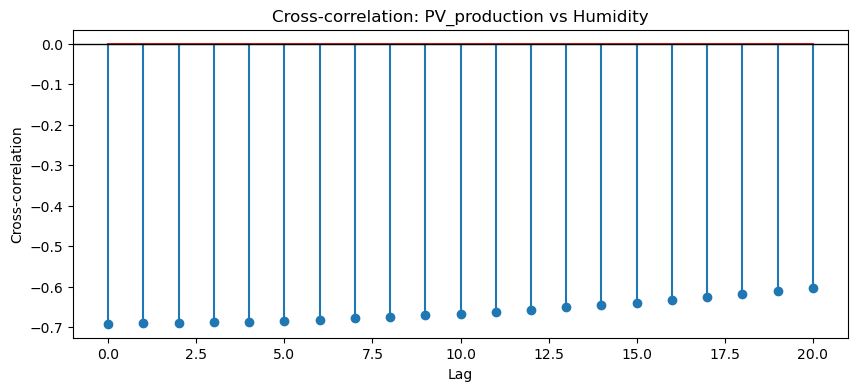

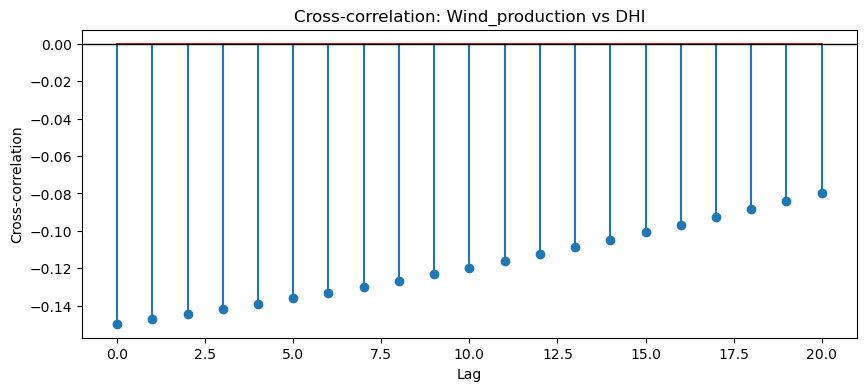

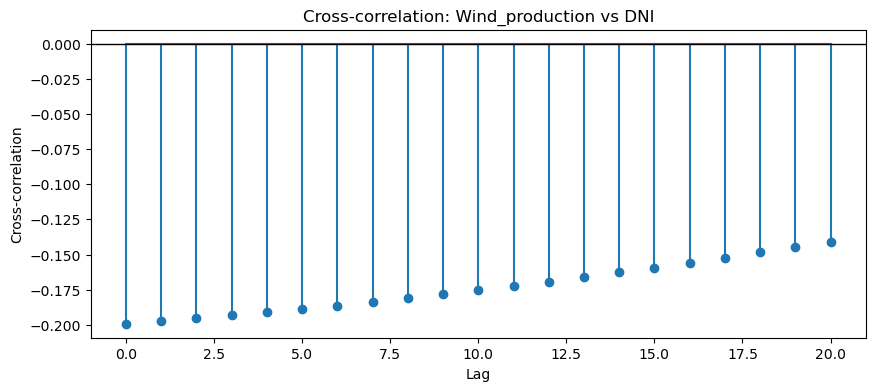

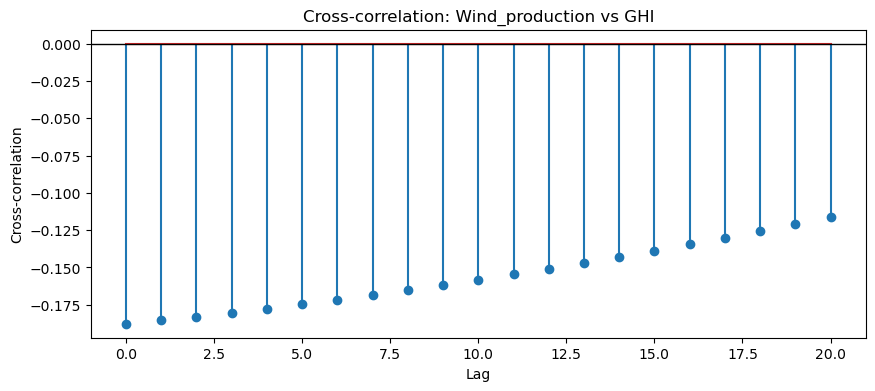

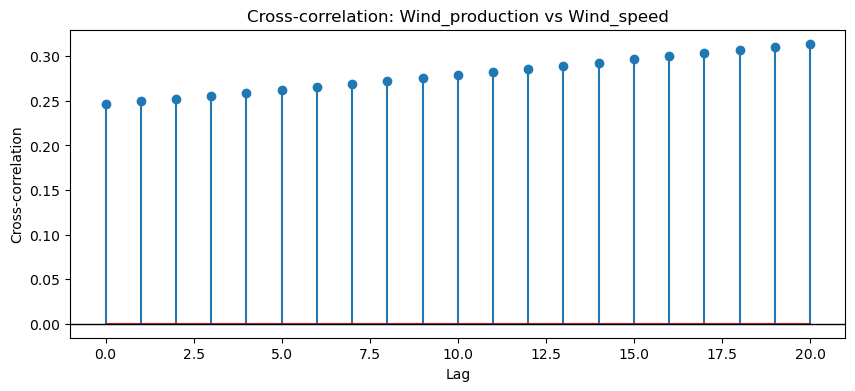

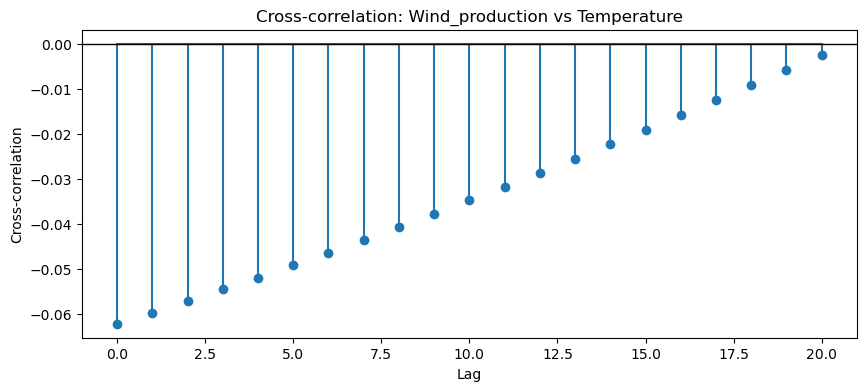

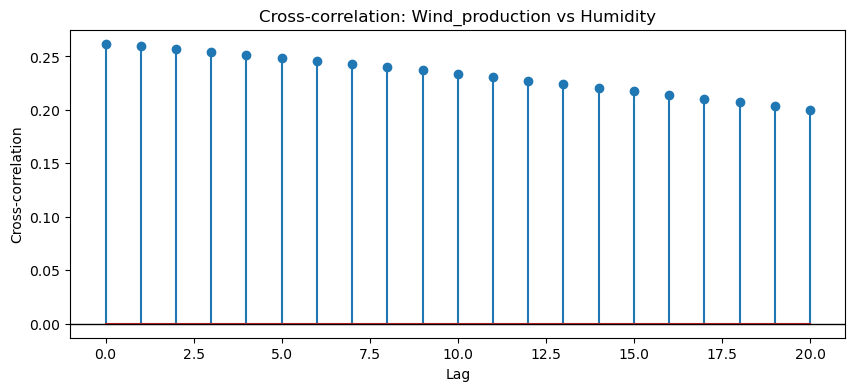

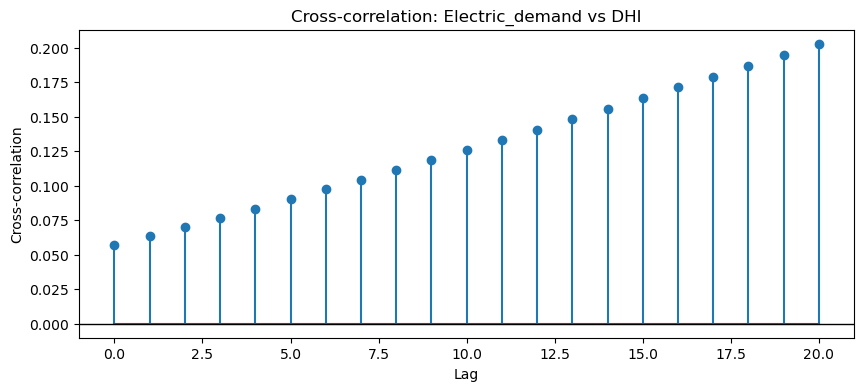

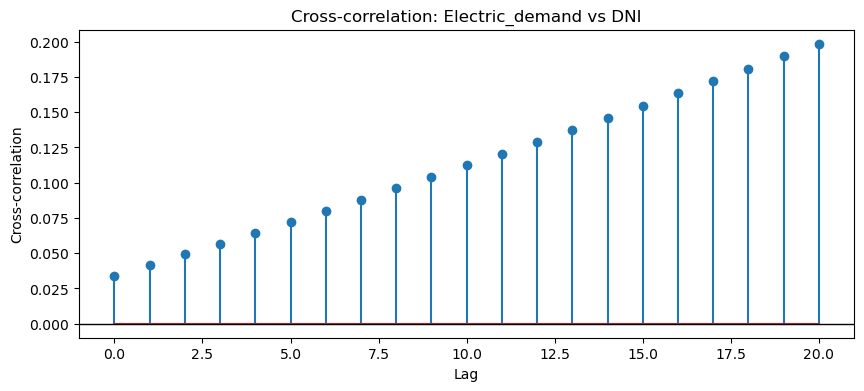

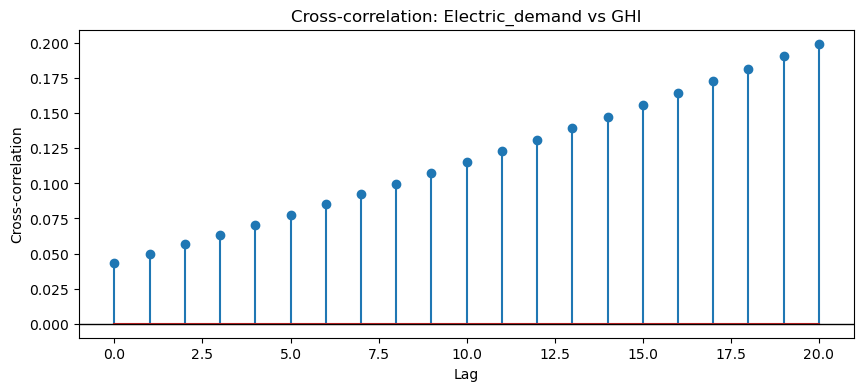

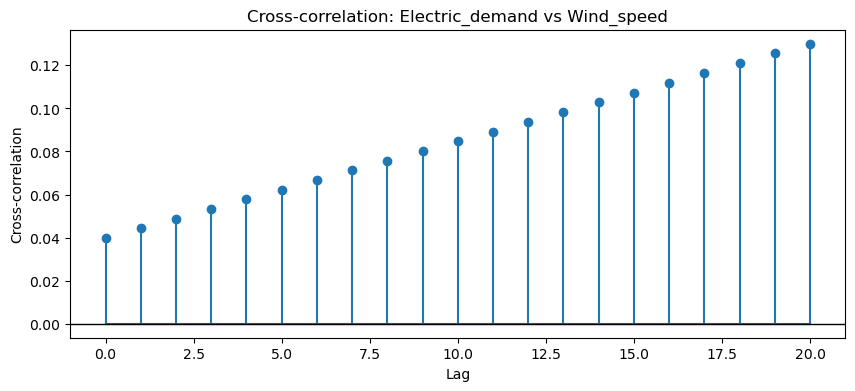

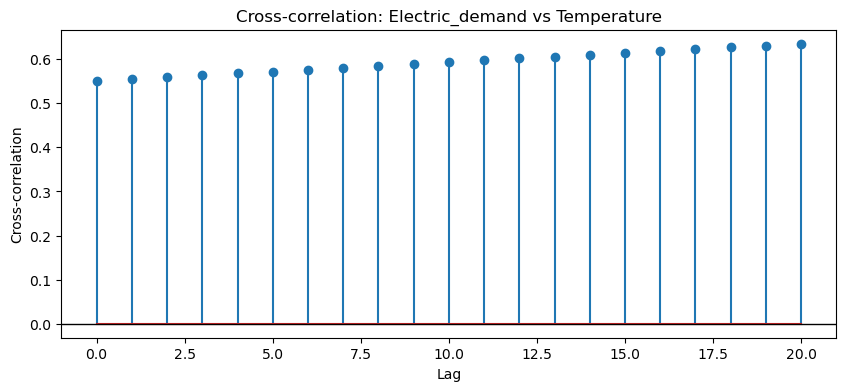

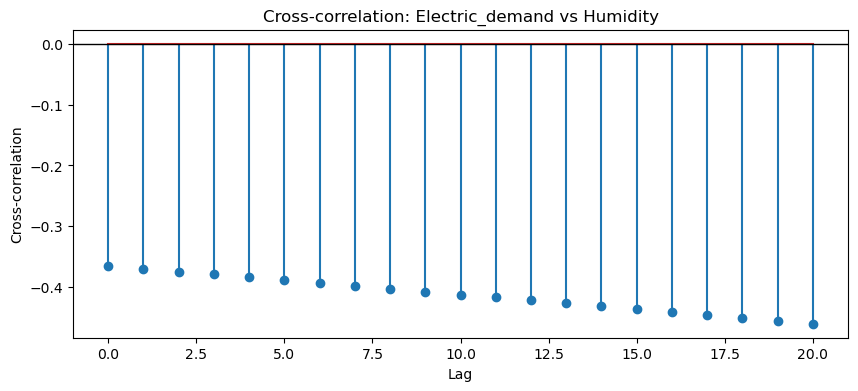

In [22]:
max_lag = 20 

def cross_correlation(y, x, max_lag=20):
    corr = ccf(y, x)  
    return corr[:max_lag+1]  

for prod in production_vars:
    for weather in weather_vars:
        y = df[prod]
        x = df[weather]
        
        corr_values = cross_correlation(y, x, max_lag=max_lag)
        lags = np.arange(0, max_lag+1)
        
        plt.figure(figsize=(10,4))
        plt.stem(lags, corr_values)
        plt.xlabel("Lag")
        plt.ylabel("Cross-correlation")
        plt.title(f"Cross-correlation: {prod} vs {weather}")
        plt.axhline(0, color='black', linewidth=1)
        plt.show()